In [1]:
import tensorflow as tf
import sys
sys.path.append("../../")
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import abc
import time
import six
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    mean_squared_error,
    accuracy_score,
    f1_score,
)
import yaml
import zipfile

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_final = pd.read_csv("df_final.csv")
num_data=len(df_final)
labels = df_final["click_flg"]
test_y = labels[int(num_data*0.9):len(df_final)]

In [3]:
with open('randomforest_1.txt', 'r') as rd:
    random_forest_pred = [float(s.strip()) for s in rd.readlines()]

In [4]:
with open('lightgbm.txt', 'r') as rd:
    lightgbm_pred_1 = [float(s.strip()) for s in rd.readlines()]

In [5]:
with open('logistic.txt', 'r') as rd:
    logistic_pred = [float(s.strip()) for s in rd.readlines()]

In [6]:
with open('output_4.txt', 'r') as rd:
    xdeep_pred = [float(s.strip()) for s in rd.readlines()]

In [7]:
with open('mlp.txt', 'r') as rd:
    mlp_pred = [float(s.strip()) for s in rd.readlines()]

In [8]:
with open('stacked_generalization.txt', 'r') as rd:
  stacked_pred = [float(s.strip()) for s in rd.readlines()]

In [9]:
y_pred = np.array(list(map(lambda x: x*10,xdeep_pred)))+ \
      np.array(list(map(lambda x: x*5,random_forest_pred)))+ \
      np.array(list(map(lambda x: x*40,logistic_pred)))+ \
      np.array(list(map(lambda x: x*10,stacked_pred))) 
print("AUC(ROC):{}".format(roc_auc_score(test_y, y_pred)))

AUC(ROC):0.7950691536755748


In [88]:
y_pred = np.array(list(map(lambda x: x*30,xdeep_pred)))+np.array(lightgbm_pred_1)+ np.array(logistic_pred)
print("AUC(ROC):{}".format(roc_auc_score(test_y, y_pred)))

AUC(ROC):0.7854811627382986


In [89]:
y_pred = np.array(stacked_pred)+ np.array(logistic_pred)
print("AUC(ROC):{}".format(roc_auc_score(test_y, y_pred)))

AUC(ROC):0.7918982424725601


Text(0,0.5,'TPR: True positive rate')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


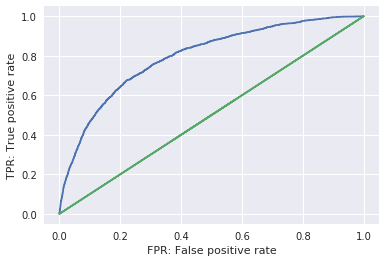

In [10]:
import pylab as pl
from sklearn import metrics
# FPR, TPR(, しきい値) を算出
roc_p = metrics.roc_curve(test_y, y_pred, drop_intermediate=False)
x = np.random.rand(len(test_y))
y = x
plt.plot(roc_p[0], roc_p[1],linestyle='-')
plt.plot(x, y)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


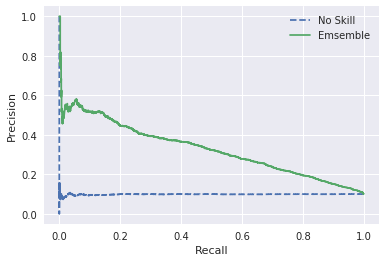

In [14]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Emsemble')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [12]:
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

AUC(PR):0.3283954893481523


In [62]:
len(test_y)

20000

In [34]:
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    recall_plus_precision_list = []
    for thres in threshold:
      pred = []
      for i in predicted:
        if i>thres:
          pred.append(1)
        else:
          pred.append(0)
      recall_plus_precision_list.append(recall_score(target, pred)+precision_score(target, pred))
      i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(recall_plus_precision_list, index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Find optimal probability threshold
#threshold = Find_Optimal_Cutoff(test_y, y_pred)
#print (threshold)

# Find prediction to the dataframe applying threshold
pred = []
for i in y_pred:
  if i>26:
    pred.append(1)
  else:
    pred.append(0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred)

array([[17740,   249],
       [ 1746,   265]])

In [35]:
from sklearn.metrics import recall_score
recall_score(test_y, pred)

0.13177523620089507

In [36]:
from sklearn.metrics import precision_score
precision_score(test_y, pred)

0.5155642023346303

In [38]:
random_pred = []
for i in no_skill_probs:
  if i>0.5:
    random_pred.append(1)
  else:
    random_pred.append(0)


In [41]:
print(confusion_matrix(test_y, random_pred))
print(recall_score(test_y, random_pred))
print(precision_score(test_y, random_pred))

[[9006 8983]
 [1009 1002]]
0.49825957235206364
0.10035052578868302


# Out Of Fold

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
class StackedGeneralization:
    def __init__(self, n_folds, train_data, train_target, test_data):
        self.n_folds = n_folds
        self.train_data = train_data
        self.train_target = train_target
        self.test_data = test_data
        self.n_classes = len(numpy.unique(train_target))
        self.skf = StratifiedKFold(n_splits=n_folds)


class Generalizer:
    def __init__(self):
        self.model = None

    def name(self):
        raise NotImplementedError

    def guess_partial(self, sg):
        assert(isinstance(sg, StackedGeneralization))
        generalizer_prediction = numpy.empty((0, 1))
        for train_index, test_index in sg.skf.split(sg.train_data, sg.train_target):
            self.train(sg.train_data[train_index],
                       sg.train_target[train_index])
            generalizer_prediction = numpy.vstack((generalizer_prediction,
                self.predict(sg.train_data[test_index]).reshape(len(test_index),1)))
        reorder_index = [test_index for _, test_indices in sg.skf.split(sg.train_data, sg.train_target) for test_index in test_indices]
        return(generalizer_prediction[reorder_index])

    def guess_whole(self, sg):
        assert(isinstance(sg, StackedGeneralization))
        return(self.guess(sg.train_data, sg.train_target, sg.test_data))

    def guess(self, input_data, input_target, test_data):
        self.train(input_data, input_target)
        return(self.predict(test_data).reshape(len(test_data),1))

    def train(self, data, label):
        raise NotImplementedError

    def predict(self, data):
        raise NotImplementedError

    @staticmethod
    def load_partial(name):
        return(numpy.load(Generalizer._partial_path(name)))

    @staticmethod
    def load_whole(name):
        return(numpy.load(Generalizer._whole_path(name)))

    @staticmethod
    def save_partial(name, prediction):
        numpy.save(Generalizer._partial_path(name), prediction)

    @staticmethod
    def save_whole(name, prediction):
        numpy.save(Generalizer._whole_path(name), prediction)

    @staticmethod
    def _partial_path(name, has_ext = True):
        return(path.join("data", "partial", Generalizer._add_ext(name, has_ext)))

    @staticmethod
    def _whole_path(name, has_ext = True):
        return(path.join("data", "whole", Generalizer._add_ext(name, has_ext)))

    @staticmethod
    def _add_ext(name, has_ext):
        if has_ext:
            return(name + '.npy')
        else:
            return(name)

In [56]:
def train_layer0(sg, generalizers, save_predictions = False):
    layer0_partition_guess = numpy.array([generalizer.guess_partial(sg) for generalizer in generalizers])

    for generalizer_index, generalizer in enumerate(generalizers):
        if save_predictions:
            Generalizer.save_partial(generalizer.name(),
                                              layer0_partition_guess[generalizer_index])
        print("log loss for {} : {}".format(
            generalizer.name(),
            log_loss(sg.train_target, layer0_partition_guess[generalizer_index, :, :])
        ))

    layer0_whole_guess = numpy.array([generalizer.guess_whole(sg) for generalizer in generalizers])
    for generalizer_index, generalizer in enumerate(generalizers):
        if save_predictions:
            Generalizer.save_whole(generalizer.name(),
                                   layer0_whole_guess[generalizer_index])

    return(layer0_partition_guess, layer0_whole_guess)

def load_layer0(filenames):
    layer0_partial_guess = numpy.array([Generalizer.load_partial(filename) for
                                        filename in filenames])
    layer0_whole_guess = numpy.array([Generalizer.load_whole(filename) for
                                        filename in filenames])
    return(layer0_partial_guess, layer0_whole_guess)

def initialize_sg(train_data, train_target, test_data):
    n_folds = 5
    return(StackedGeneralization(n_folds, train_data, train_target, test_data))

In [57]:
class RandomForest(Generalizer):
    def name(self):
        return("random_forest")

    def train(self, data, label):
        rfc = RandomForestClassifier(n_estimators = 300, max_depth = 32, min_samples_split = 16, max_leaf_nodes = 60)
        self.model = rfc.fit(data, label)

    def predict(self, data):
        return(self.model.predict_proba(data)[:, 1])
class Lightgbm(Generalizer):
    def name(self):
        return("light  gbm")

    def train(self, train_x, train_y):
      train_data = lgb.Dataset(train_x, label=train_y)
      eval_data = lgb.Dataset(test_x, label=test_y, reference= train_data)
      self.model = lgb.train(params, train_data, valid_sets=eval_data, fobj=focal_loss, feval=focal_loss_eval)
    def predict(self, data):
        return(self.model.predict(data, num_iteration=self.model.best_iteration))
class LR(Generalizer):
    def name(self):
        return("logistic_regression")

    def train(self, data, label):
        rfc = LogisticRegression()
        self.model = rfc.fit(data, label)

    def predict(self, data):
        return(self.model.predict_proba(data)[:, 1])

In [58]:
# featureとラベルをそれぞれ抽出してtrain/testに分割
feature_cols =  ['browser',
       'slot_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]


In [59]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

In [60]:
list_cols = ['browser',
       'slot_id', 'campaign_id', 'creative_id',
       'region', 'request_hour']
te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x = te.transform(train_x)
test_x = te.transform(test_x)

In [ ]:
!conda install -y -c conda-forge lightgbm

In [61]:
params={"objective": "binary",
        "boosting_type": "gbdt",
        'feature_fraction': 0.27914384688479543, 
        'max_depth': 73, 
        "max_bin": 256,
        'min_child_weight': 9, 
        'subsample': 0.9878747678936071, 
        'min_data_in_leaf': 428, 
        'num_leaves': 76, 
        'min_child_samples': 310, 
        'learning_rate': 0.641945204259818, 
        'drop_rate': 0.9931413183540156, 
        'lambda_l1': 6,
        "verbose": 2,
        "is_unbalance": False,
        "max_drop": 50,
        "min_split_gain": 0,
        "verbosity":-1
       }
from scipy.misc import derivative
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  def fl(x,t):
  	p = 1/(1+np.exp(-x))
  	return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
  partial_fl = lambda x: fl(x, y_true)
  grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
  hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
  return grad, hess

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
  a,g = alpha, gamma
  y_true = dtrain.label
  p = 1/(1+np.exp(-y_pred))
  loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
  # (eval_name, eval_result, is_higher_better)
  return 'focal_loss', np.mean(loss), False
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.)

In [ ]:
import numpy
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
sg = initialize_sg(train_x.values, train_y.values, test_x.values)
# for ad-hoc training
generalizers = [RandomForest(), Lightgbm(), LR()]
layer0_partition_guess, layer0_whole_guess = train_layer0(sg, generalizers)

# loading predictions
#layer0_partition_guess, layer0_whole_guess = load_layer0(["random_forest","extra_trees"])

result = LR().guess(
  numpy.hstack(layer0_partition_guess),
  sg.train_target,
  numpy.hstack(layer0_whole_guess))


In [64]:
print(roc_auc_score(test_y, result))

0.7820694004422117


In [80]:
y_pred = []
for i in result:
  for j in i:
    y_pred.append(j)

In [82]:
y_pred_str = [str(n) for n in y_pred]
with open('stacked_generalization.txt', 'w') as rd:
    rd.writelines('\n'.join(y_pred_str))

In [ ]:
y_pred = list(map(lambda x: x*30,xdeep_pred)) + result
print(roc_auc_score(test_y, y_pred/2))

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


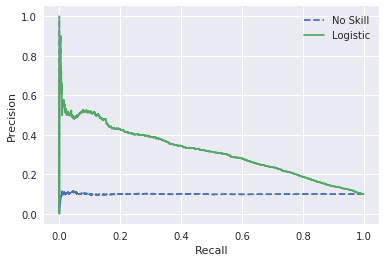

AUC(PR):0.3151405771482678


In [65]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, result)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))